In [45]:
import pandas as pd
import numpy as np 

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.api import qqplot, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

Car_raw = pd.read_csv("/home/piai/Preprocessed_Car.csv", encoding = 'euc-kr')
Car_raw.head()

# Car_raw_dummy = pd.get_dummies(Car_raw, drop_first = True)
# Car_raw_dummy.head()

,Price,Year,Kilometers_Driven,Mileage,Engine,Power,Seats
0,2069.50,2003,80000,12.80,1489,35.5,5
1,26918.78,2014,84004,20.38,1968,143.0,5
2,25293.84,2014,79271,20.38,1968,143.0,5
3,29509.48,2016,20003,20.38,1968,143.0,5
4,28972.94,2016,39000,20.38,1968,143.0,5


다중공성선 확인 

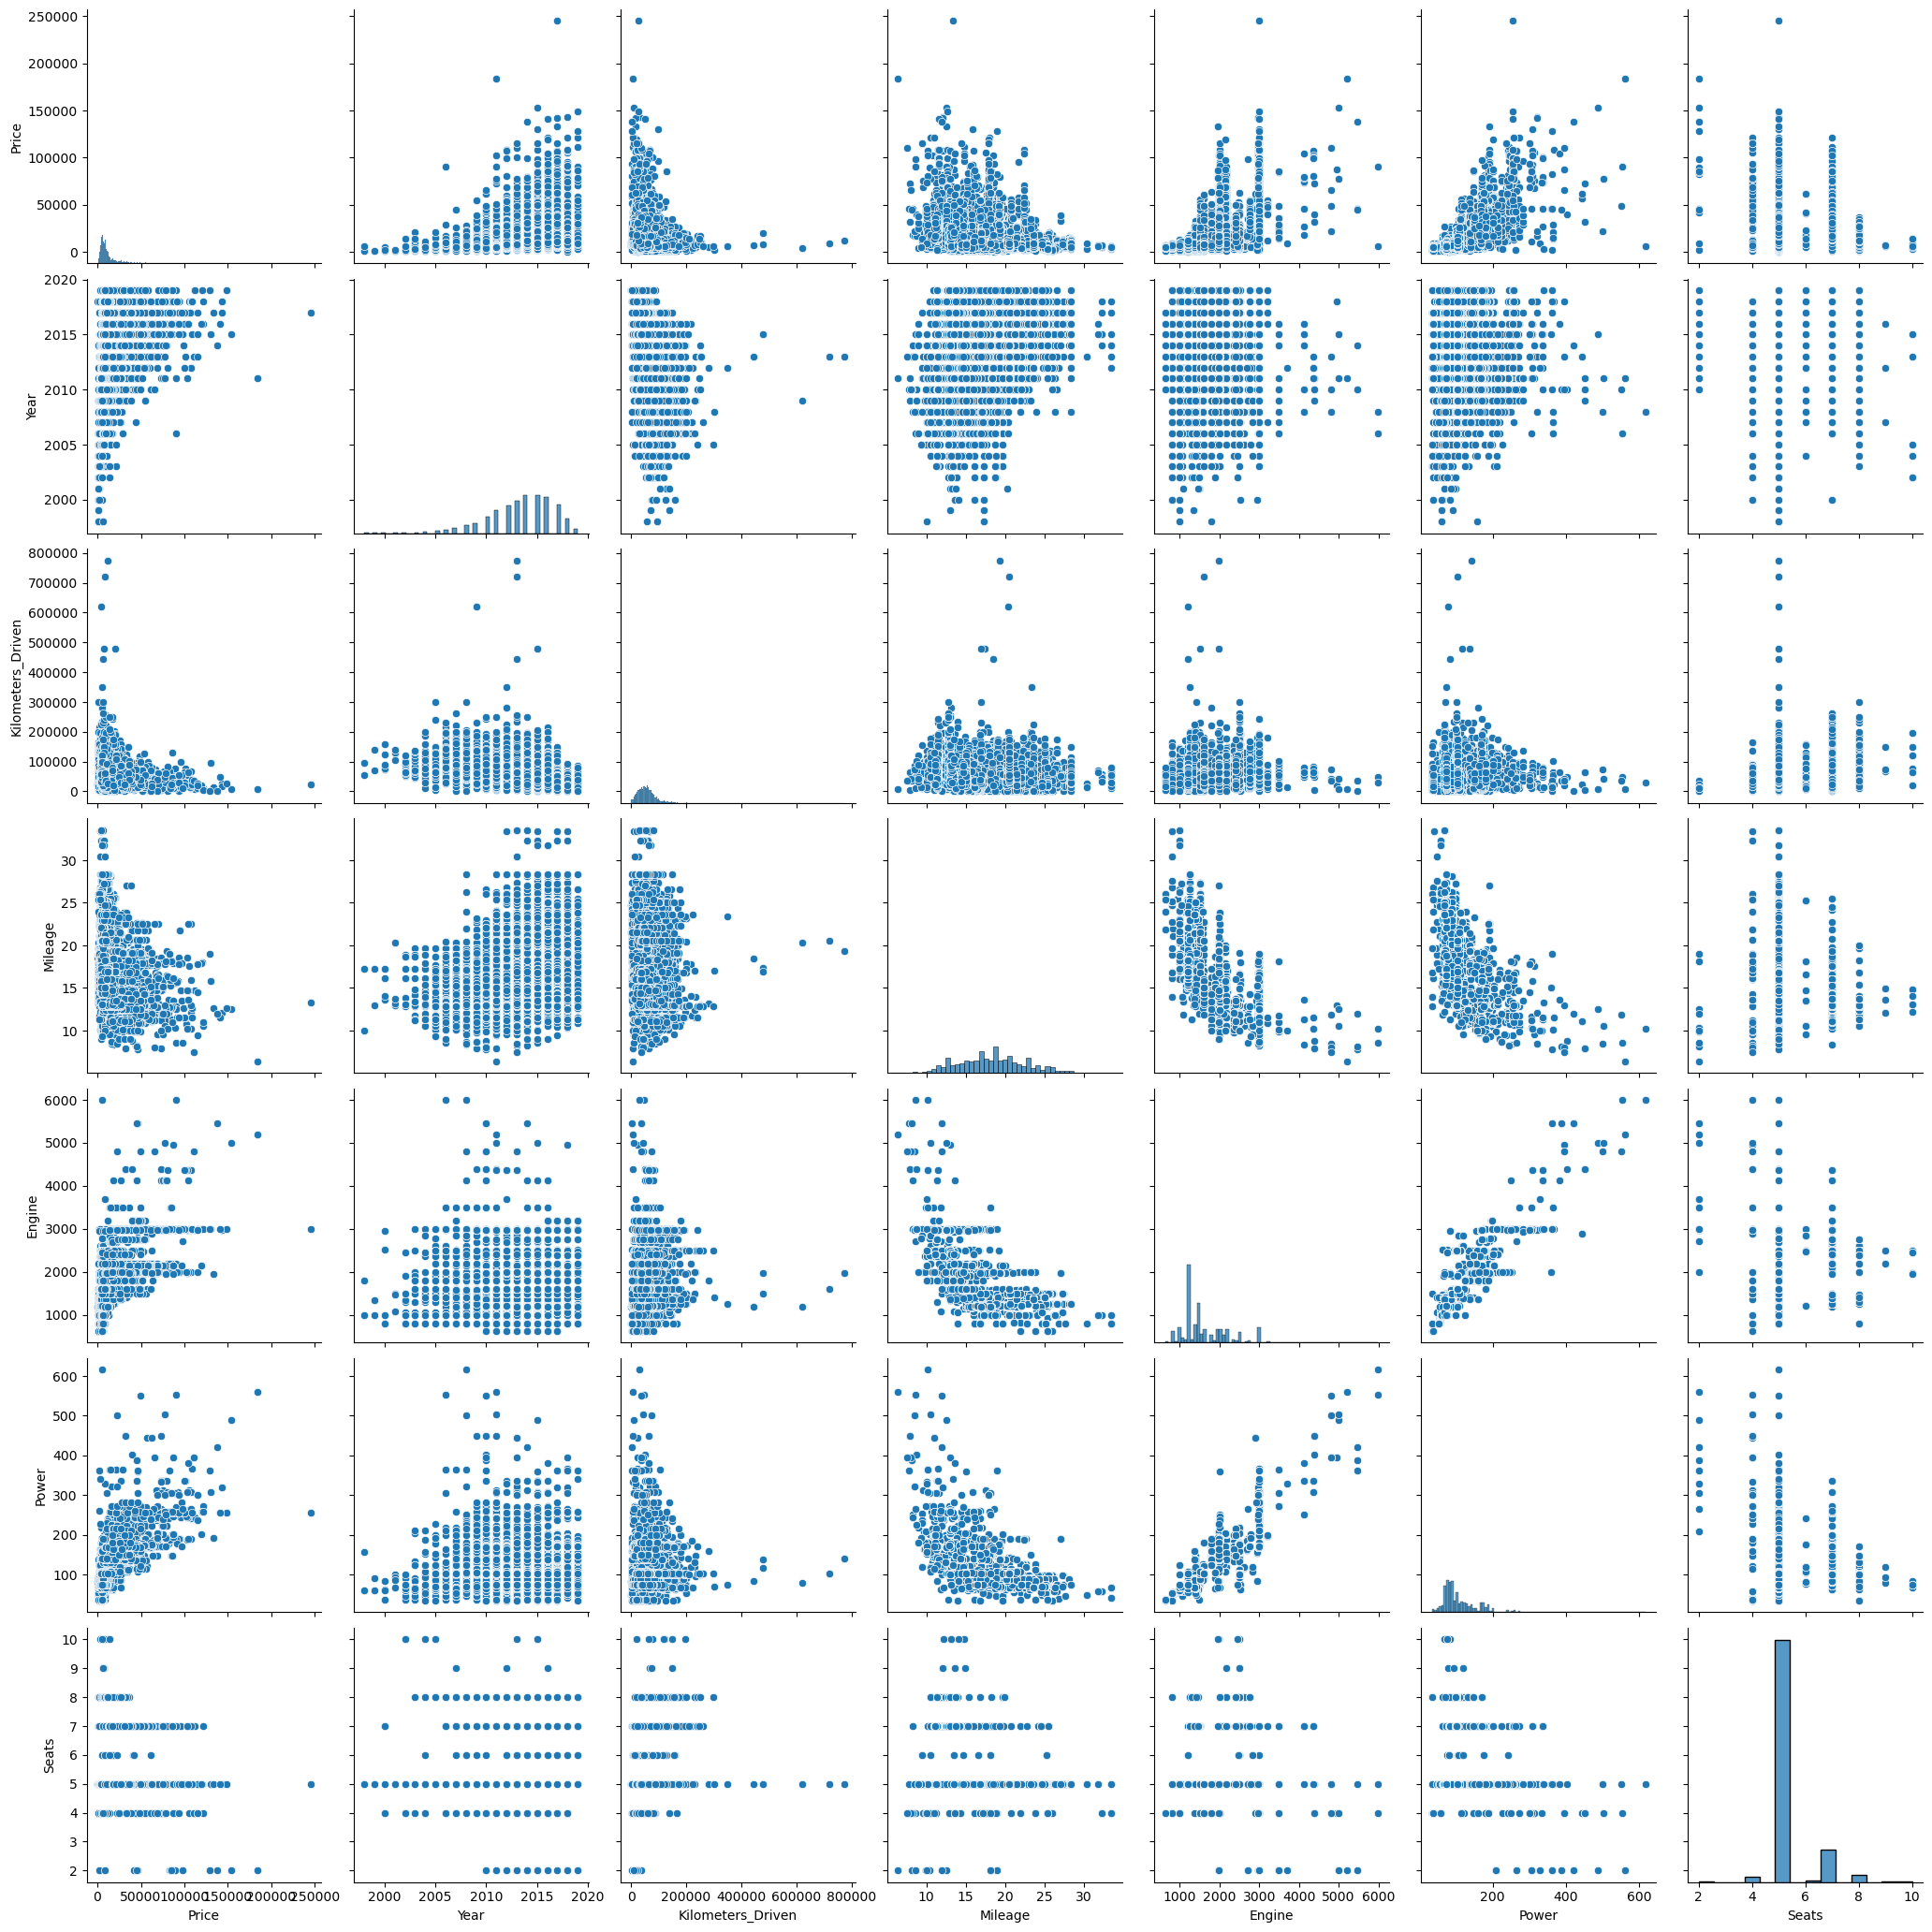

In [47]:
sns.pairplot(Car_raw, height=3)

In [48]:
Car_raw.corr().round(3)

,Price,Year,Kilometers_Driven,Mileage,Engine,Power,Seats
Price,1.000,0.290,-0.164,-0.325,0.631,0.751,0.058
Year,0.290,1.000,-0.448,0.299,-0.070,0.013,0.003
Kilometers_Driven,-0.164,-0.448,1.000,-0.141,0.165,0.002,0.215
Mileage,-0.325,0.299,-0.141,1.000,-0.647,-0.551,-0.356
Engine,0.631,-0.070,0.165,-0.647,1.000,0.860,0.411
Power,0.751,0.013,0.002,-0.551,0.860,1.000,0.098
Seats,0.058,0.003,0.215,-0.356,0.411,0.098,1.000


POWER와 ENGINE 간의 높은 상관관계(양)가 나타남, 마일리지와 엔진간의 음의 상관관계가 나타남, 마일리지와 파워 간의 음의 상관관계가 나타남 

In [49]:
Car_raw_train, Car_raw_test = train_test_split(Car_raw, test_size = 0.3, random_state = 1234)
print("train data size: {}".format(Car_raw_train.shape))
print("test data size: {}".format(Car_raw_test.shape))

train data size: (4952, 7)
test data size: (2123, 7)


In [52]:
reg_model = smf.ols(formula = "Price ~ Year+ Kilometers_Driven + Mileage + Engine + Power + Seats", data = Car_raw_train)

reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     1478.
Date:                Thu, 31 Oct 2024   Prob (F-statistic):               0.00
Time:                        23:56:04   Log-Likelihood:                -52755.
No. Observations:                4952   AIC:                         1.055e+05
Df Residuals:                    4945   BIC:                         1.056e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -2.927e+06   1.13e+0

분산분석 결과 P값이 유의수준 0.05보다 작으므로 회귀모델로서 유의  설명력은 모델을 통하여 64.1%를 설명할 수 있음

In [57]:
Car_raw_train_x = Car_raw.drop("Price", axis = 1)
Car_raw_train_x_const = add_constant(Car_raw_train_x)

Car_raw_vif = pd.DataFrame() 
Car_raw_vif["variable"] = Car_raw_train_x_const.columns 
Car_raw_vif["VIF"] = [variance_inflation_factor(Car_raw_train_x_const.values, i) for i in range(Car_raw_train_x_const.shape[1])]

Car_raw_vif.sort_values("VIF", ascending = True).round(2)

,variable,VIF
2,Kilometers_Driven,1.39
1,Year,1.50
6,Seats,1.86
3,Mileage,2.06
5,Power,5.97
4,Engine,7.35
0,const,607872.96


일단 파워와 엔진은 위 그래프상 양의 상관관계를 보이나, VIF가 10미만이므로 변수간 상관관계가 낮고, 각 변수가 독립적으로 설명력을 가질 가능성이 높아
삭제하지 않는 것으로 검토 

In [61]:
reg_model = smf.ols(formula = "Price ~ Kilometers_Driven + Year + Seats + Mileage + Power + Engine", data = Car_raw_train)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     1478.
Date:                Fri, 01 Nov 2024   Prob (F-statistic):               0.00
Time:                        00:12:14   Log-Likelihood:                -52755.
No. Observations:                4952   AIC:                         1.055e+05
Df Residuals:                    4945   BIC:                         1.056e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -2.927e+06   1.13e+0

마일리지의 경우 P-VALUE가 0.05 이상이므로 제거 

In [64]:
reg_model = smf.ols(formula = "Price ~ Kilometers_Driven + Year + Seats + Power + Engine", data = Car_raw_train)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     1773.
Date:                Fri, 01 Nov 2024   Prob (F-statistic):               0.00
Time:                        00:15:40   Log-Likelihood:                -52755.
No. Observations:                4952   AIC:                         1.055e+05
Df Residuals:                    4946   BIC:                         1.056e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -2.951e+06   1.05e+0

등분산성 검정

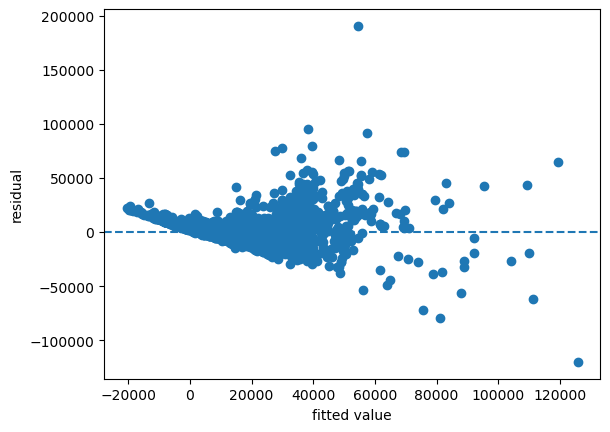

In [65]:
plt.scatter(reg_result.fittedvalues, reg_result.resid)
plt.xlabel("fitted value")
plt.ylabel("residual")
plt.axhline(y=0, linestyle = "--")

등분산성 미충족 

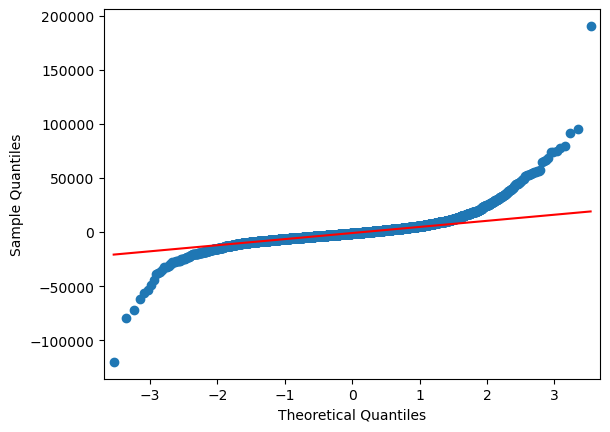

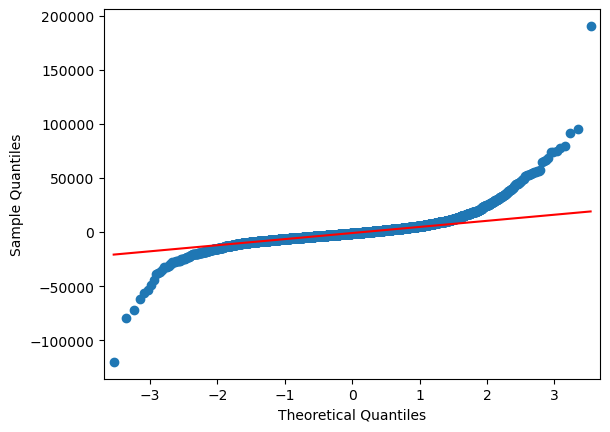

In [66]:
qqplot(reg_result.resid, line = "q")

정규성 미충족

따라서, 엔진과 파워를 삭제 

In [67]:
reg_model = smf.ols(formula = "Price ~ Kilometers_Driven + Year + Seats", data = Car_raw_train)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     152.1
Date:                Fri, 01 Nov 2024   Prob (F-statistic):           2.67e-94
Time:                        00:22:07   Log-Likelihood:                -55079.
No. Observations:                4952   AIC:                         1.102e+05
Df Residuals:                    4948   BIC:                         1.102e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -2.775e+06   1.67e+0

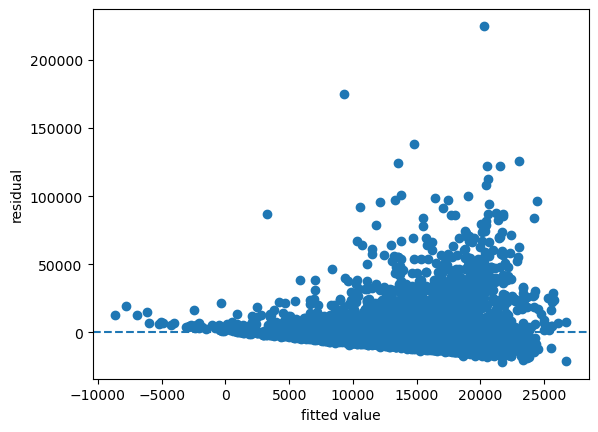

In [68]:
plt.scatter(reg_result.fittedvalues, reg_result.resid)
plt.xlabel("fitted value")
plt.ylabel("residual")
plt.axhline(y=0, linestyle = "--")

정규성 미충족

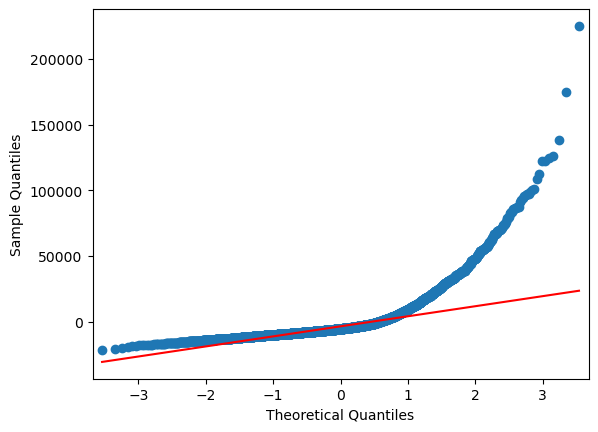

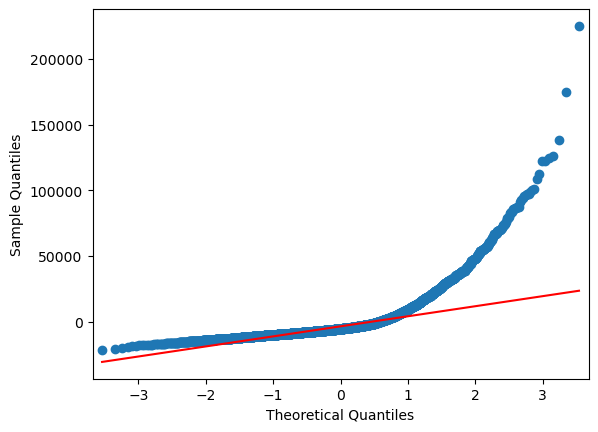

In [69]:
qqplot(reg_result.resid, line = "q")

정규성 미충족